Title of the Analysis
---

Short description of what's being done
* Data:
* Aim:
* Challenges: 

# Getting Started

Here, we load in all required packages, the data and if necesssary, additional annotations.

## Load Packages

Load in all relevant packages and set the python paths. Configure plotting parameters, set a directory for figures, results and the data.

In [1]:
# only want to see warning once
import warnings
warnings.filterwarnings(action='once') 

In [2]:
# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import seaborn as sns
import scipy
import os
import sys
import re

/home/marius/anaconda3/envs/scvelo_bench/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
# set the path to the home directory of this project
base_path = os.path.dirname(os.getcwd())
base_path

'/projects/utility_functions'

In [9]:
# if it exists, load in a paths.py file
try:
    import paths
    print('Found a paths.py file.')
    paths = paths.get_paths()
    print(paths)
except:
    print('No paths.py file found. ')

Found a paths.py file.
{'utility_functions': '/projects/utility_functions/'}


In [12]:
# add to the python path
try:
    sys.path.insert(0, paths["utility_functions"])
    
    # import custom modules (should be in the python path now)
    import utils
    
    print("Added to the python path and imported custom modules.")
except:
    print('Did not add anythin to the python path.')
# ... add more to the python path

Added to the python path and imported custom modules.


In [13]:
# import scanpy, scvelo and velocyto
import scanpy as sc
import scvelo as scv
import velocyto as vcy

In [14]:
# logging
scv.logging.print_versions()
print('Velocyto version = {}'.format(vcy.__version__))

scvelo==0.1.16  scanpy==1.4  anndata==0.6.18  loompy==2.0.17  numpy==1.15.4  scipy==1.2.0  matplotlib==3.0.2  sklearn==0.20.2  pandas==0.24.0  
Velocyto version = 0.17.17


In [17]:
# parameters for scvelo and scanpy
scv.settings.set_figure_params(frameon = True, style='scvelo')
sc.settings.verbosity = 3 

In [18]:
# write
write_path = 'write'
if os.path.isdir(os.path.join(base_path, write_path)):
    print('Found directory {!r}.'.format(write_path))
    results_file = os.path.join(base_path, write_path, 'FILENAME.h5ad')
    
# data 
data_path_name = 'data'
if os.path.isdir(os.path.join(base_path, data_path_name)):
    print('Found directory {!r}.'.format(data_path_name))
    data_path = os.path.join(base_path, data_path_name)
    
# figures
figures_path = 'figures'
if os.path.isdir(os.path.join(base_path, figures_path)):
    print('Found directory {!r}.'.format(figures_path))
    sc.settings.figdir = os.path.join(base_path, figures_path)

## Import Data

In [19]:
# import data
adata = sc.datasets.paul15()

... 100%

... storing 'paul15_clusters' as categorical


In [20]:
# make unique
adata.var_names_make_unique()

In [21]:
# cell and gene numbers
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

In [22]:
# spliced and unspliced numbers
scv.utils.show_proportions(adata)

Abundance of []: []


## Additional Annotations

Import additionall annotations. Ideally, the path would be stored in ```paths```, or given relative to the ```base_path```.

In [23]:
paths

{'utility_functions': '/projects/utility_functions/'}

In [24]:
base_path

'/projects/utility_functions'

In [25]:
# label mitochondtial genes
regex = re.compile('^(mt).*', re.IGNORECASE)
mito_genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
adata.var['mito'] = False
adata.var.loc[mito_genes, 'mito'] = True
print('Found {} mito genes and annotated.'.format(len(mito_genes)))

Found 15 mito genes and annotated.


In [26]:
mito_genes[:5]

['Mt1', 'Mt2', 'Mta1', 'Mta2', 'Mta3']

In [27]:
# label batches
adata.obs['batch'] = '1'
adata.obs.loc[adata.obs_names[:int(adata.n_obs/2)], 'batch'] = '0'

In [28]:
# compute qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=True)
adata.obs.head()

,paul15_clusters,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
0,7MEP,0,277,5.627621,353.0,5.869297,33.427762,49.858357,78.186969,100.000000,0.0,0.000000,0.000000
1,15Mo,0,1021,6.929517,2556.0,7.846590,31.259781,41.979656,55.555556,79.616588,9.0,2.302585,0.352113
2,3Ery,0,1466,7.290975,4649.0,8.444622,22.112282,31.490643,44.246074,68.186707,43.0,3.784190,0.924930
3,15Mo,0,1415,7.255591,4486.0,8.408939,27.440927,36.714222,49.264378,71.912617,11.0,2.484907,0.245207
4,3Ery,0,1505,7.317212,5205.0,8.557567,21.690682,30.605187,43.342939,67.877041,45.0,3.828641,0.864553


## Quality Control

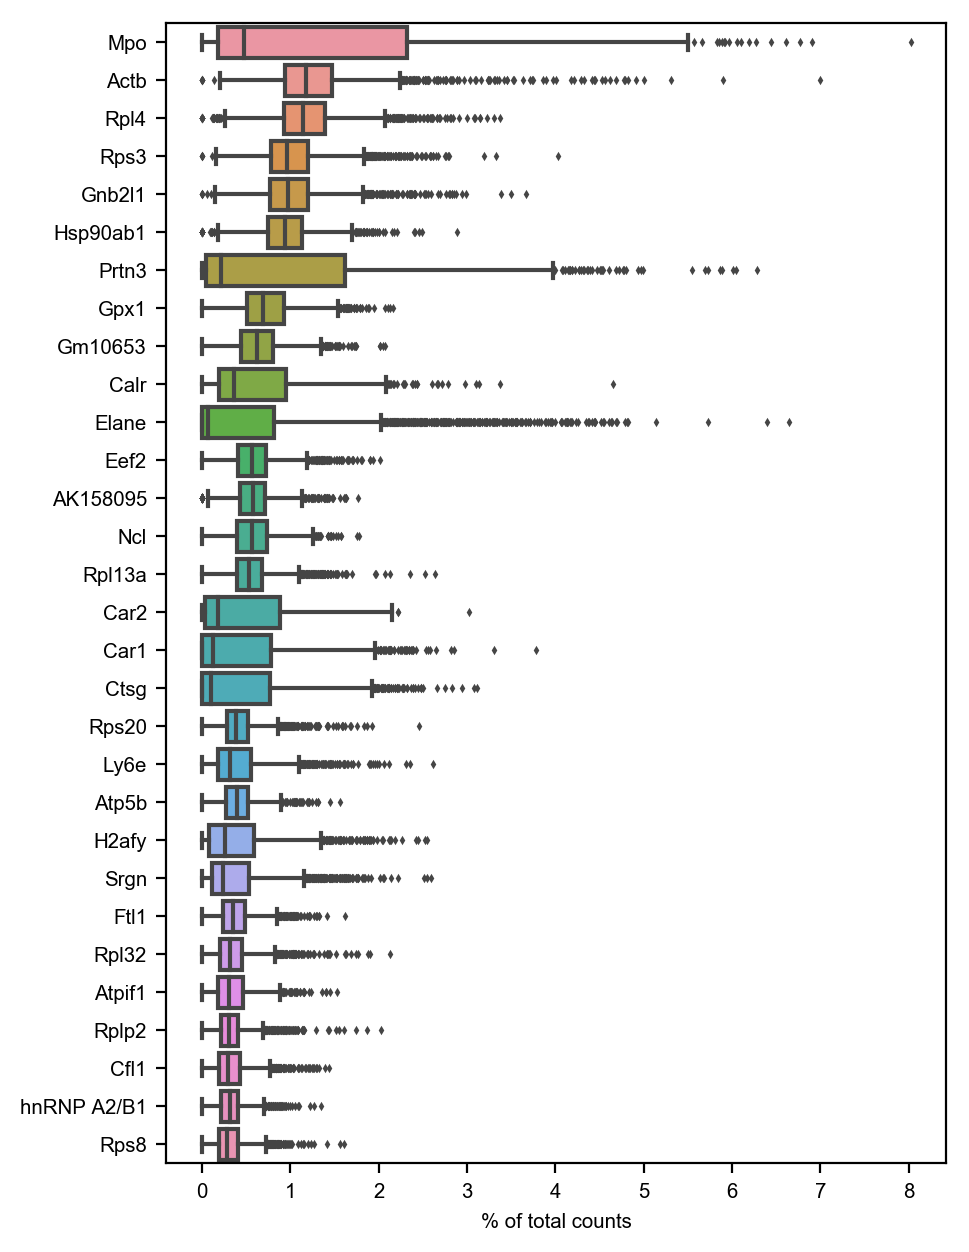

In [29]:
# start with looking at counts in the raw adata object
sc.pl.highest_expr_genes(adata)

... storing 'batch' as categorical


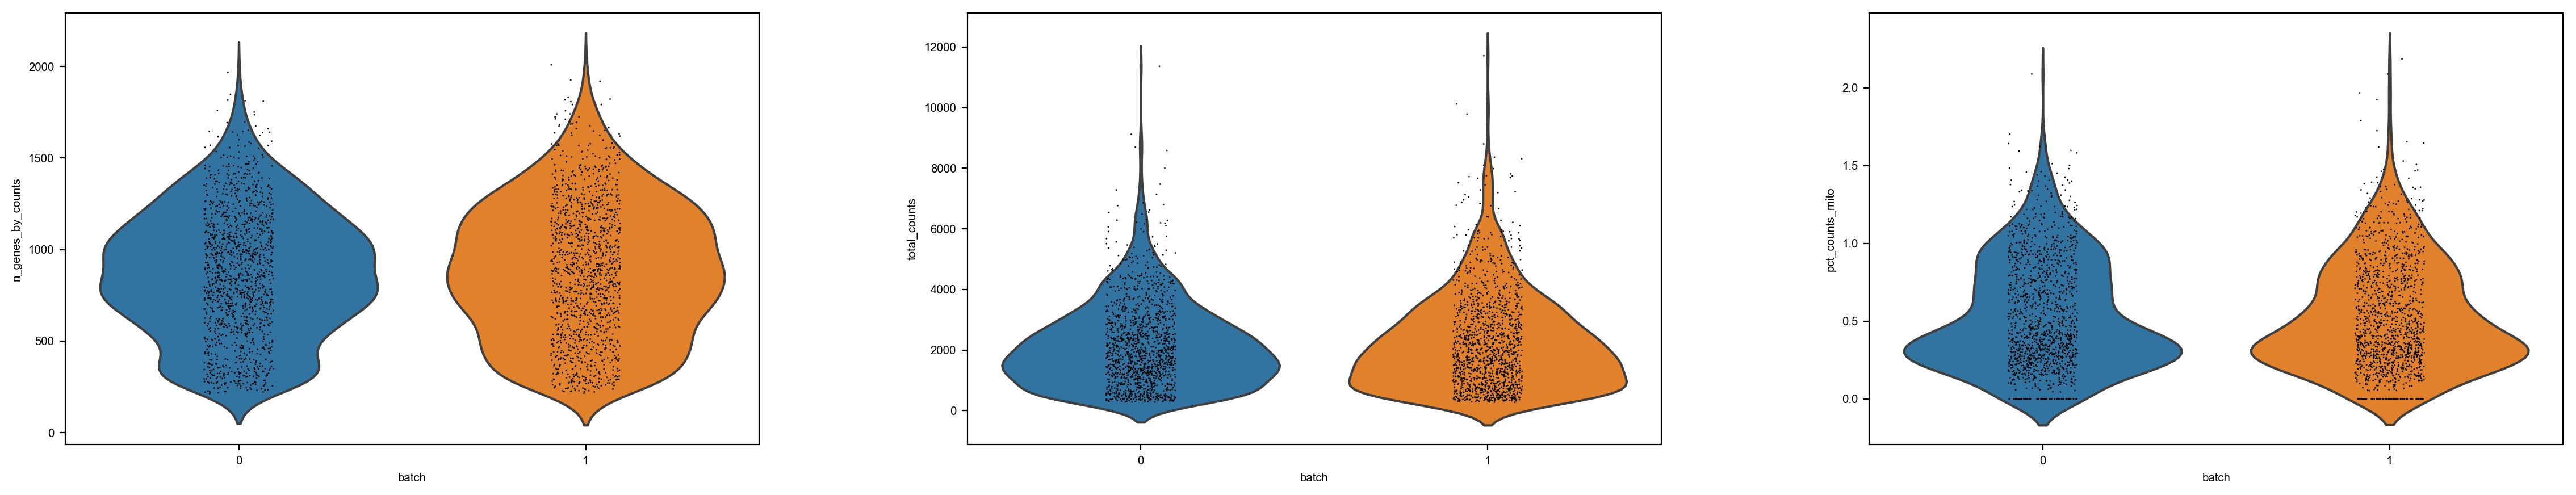

In [30]:
# check out quality metric across batches
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'], groupby='batch')

In [31]:
# visualise as histograms
utils.interactive_histograms(adata, keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mito'])

Loading BokehJS ...

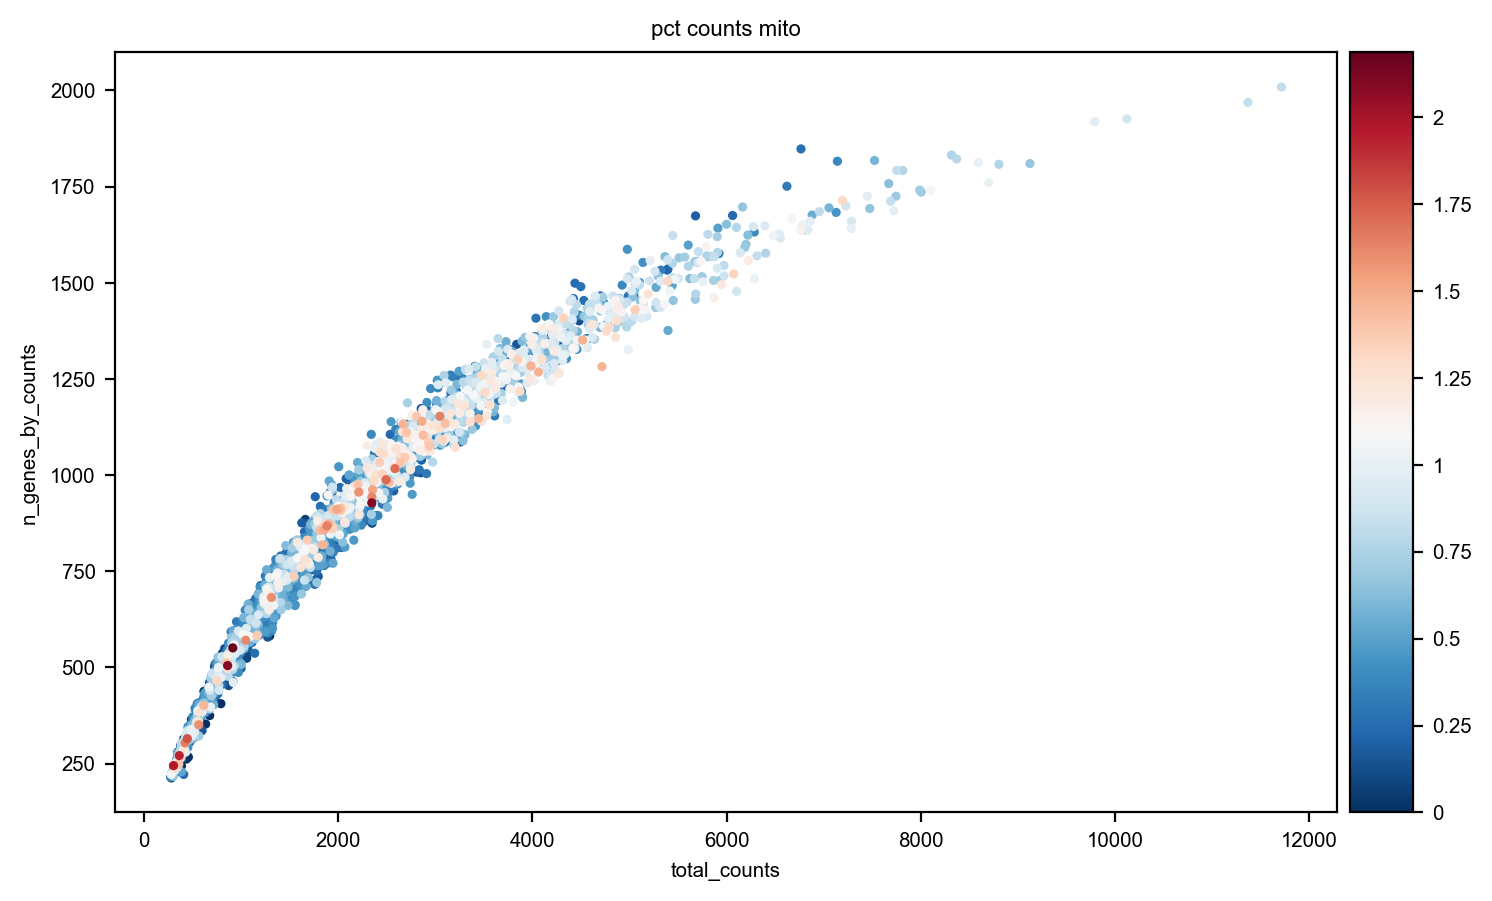

In [32]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mito')

## Filtering

We will filter out the human and the viral genes, and we will look at some quality measures for the actual mouse genes.

In [34]:
original_numbers = utils.print_numbers(adata, groupby='batch', return_numbers=True)

1365 cells in batch 0
1365 cells in batch 1
Total: 2730 cells, 3451 genes


In [35]:
# basic filtering of cells and genes
sc.pp.filter_cells(adata, min_genes=200)
# filter based on spliced/unspliced reads per cell
scv.pp.filter_genes(adata, min_counts=20, min_counts_u=10, min_cells=3)
utils.print_numbers(adata, groupby='batch')

1365 cells in batch 0
1365 cells in batch 1
Total: 2730 cells, 3451 genes


In [36]:
# filter cells based on total counts/n_genes
adata = adata[adata.obs['total_counts'] < 8000].copy()
utils.print_numbers(adata, groupby='batch')

1360 cells in batch 0
1358 cells in batch 1
Total: 2718 cells, 3451 genes


In [37]:
# filter cells based on mitochondtial activity
adata = adata[adata.obs['pct_counts_mito'] < 2]
utils.print_numbers(adata, groupby='batch')

1359 cells in batch 0
1356 cells in batch 1
Total: 2715 cells, 3451 genes


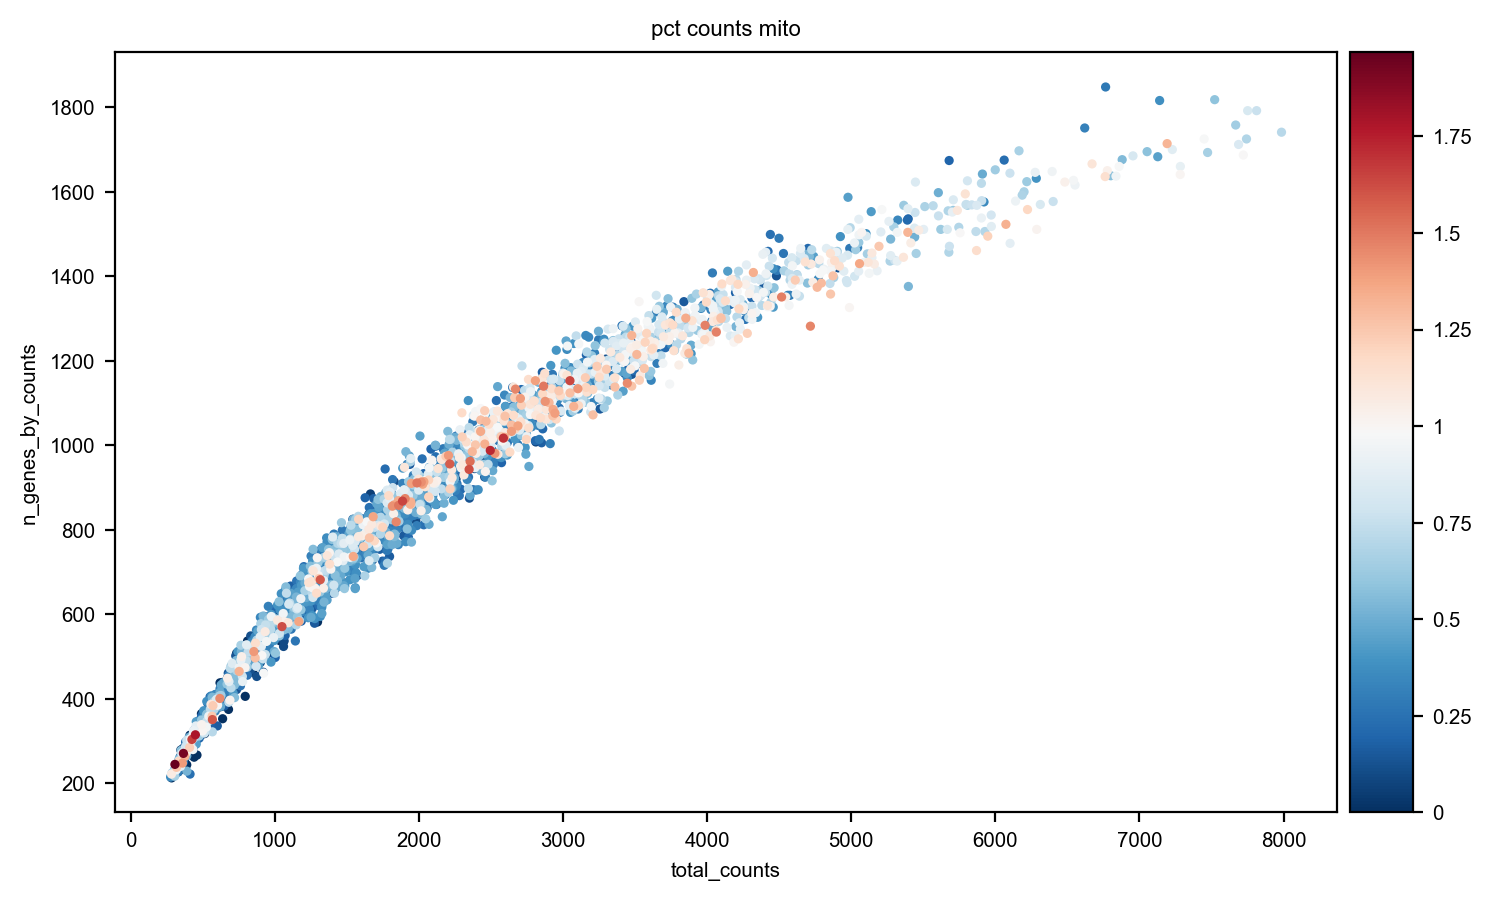

In [38]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mito')

In [39]:
# summary on the filtering
for batch in adata.obs['batch'].cat.categories:
    n_cells = n_cells_0 = adata[adata.obs['batch'] == batch].n_obs
    print('Filtered out {} cells or {:2.2f} % of batch {}.'.format(
        original_numbers[batch]-n_cells, 
        100*(original_numbers[batch]-n_cells)/original_numbers[batch],
         batch))

Filtered out 6 cells or 0.44 % of batch 0.
Filtered out 9 cells or 0.66 % of batch 1.


## Normalisation

In [40]:
# normalize per cell - we use scvelo here to normalize to initial cell size
scv.pp.normalize_per_cell(adata, use_initial_size=True)

Normalized count data: X.


In [41]:
# log transform and set .raw
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.log1p(adata)

In [42]:
# batch effect removal
sc.pp.combat(adata, key='batch')

Standardizing Data across genes.
found 2 batches
found 0 categorical variables:	
Fitting L/S model and finding priors
Finding parametric adjustments
/home/marius/anaconda3/envs/scvelo_bench/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:196: RuntimeWarning: divide by zero encountered in true_divide
  b_prior[i],


Adjusting data


In [43]:
# filter on highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


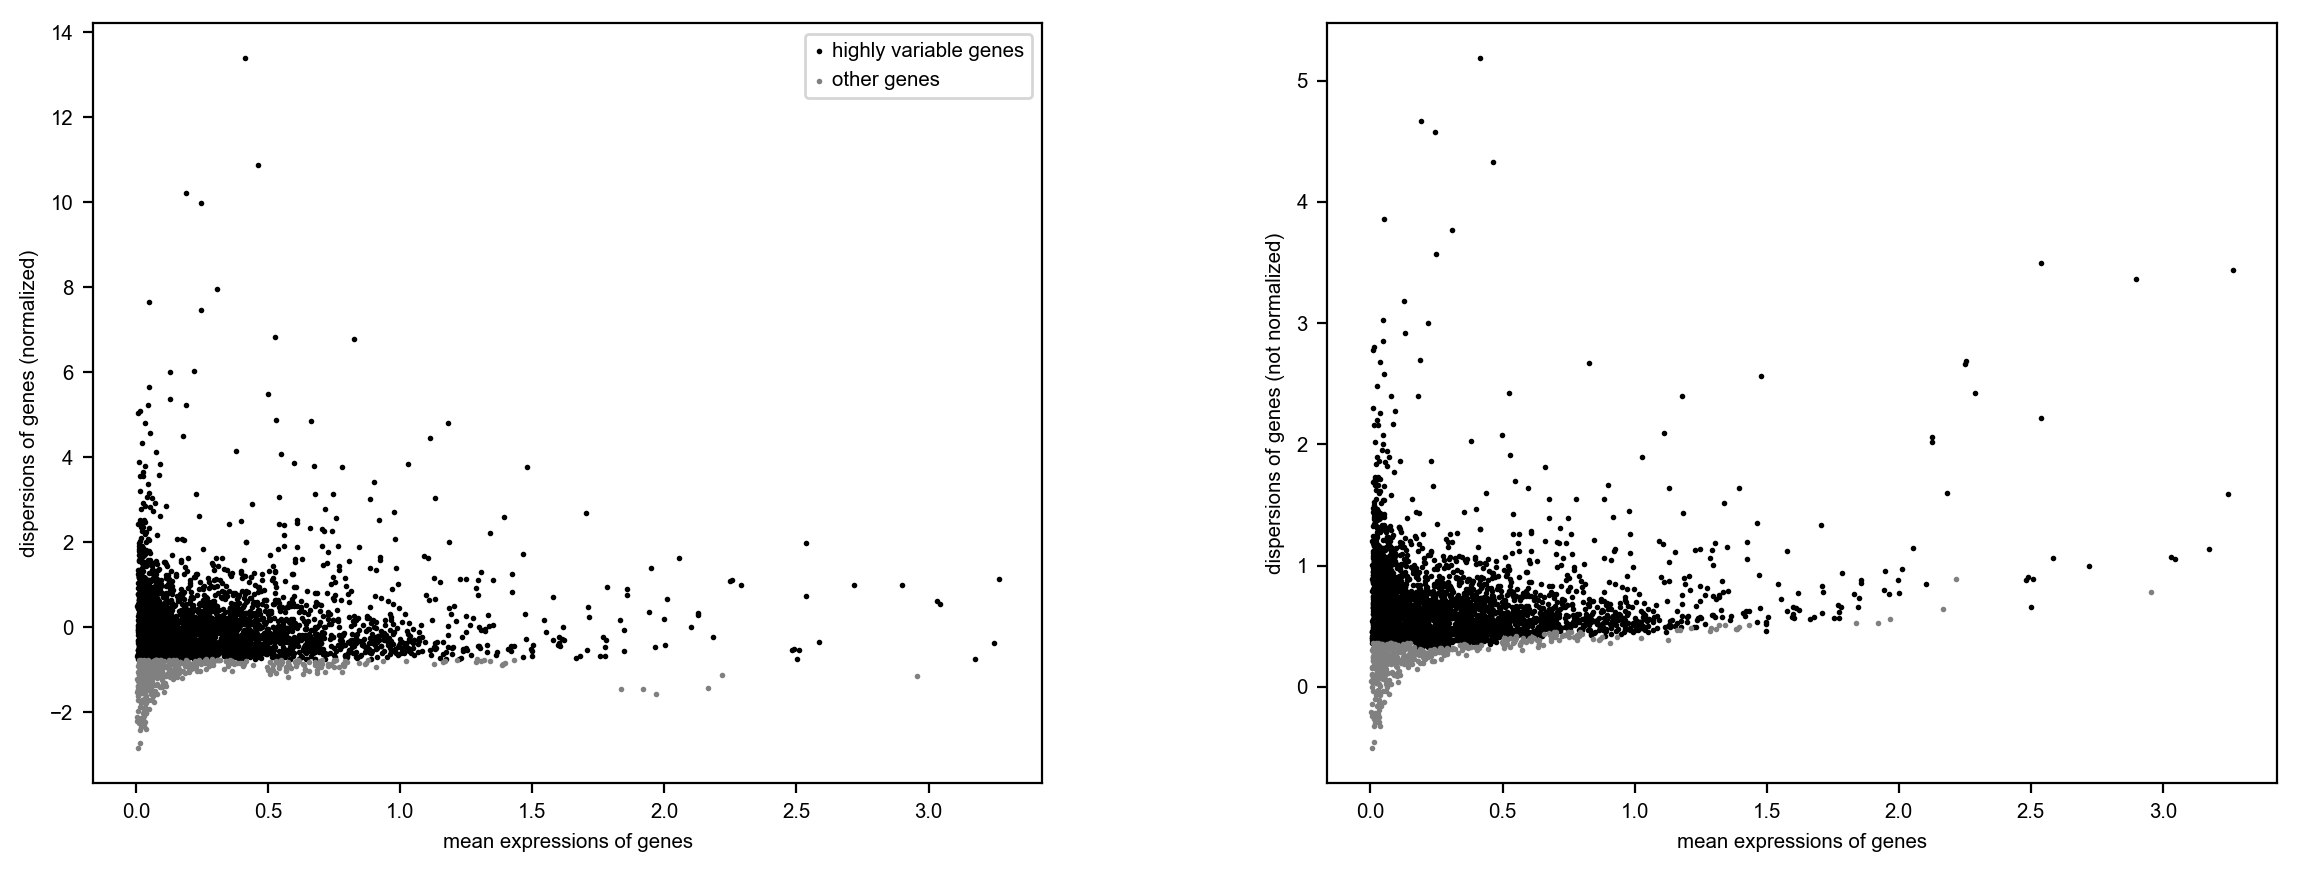

In [44]:
# plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [45]:
# for scvelo, genes really need to be filtered out so far
# adata = adata[:, adata.var['highly_variable'] == True].copy()
# utils.print_numbers(adata)

In [46]:
# regress out the count depth effect
sc.pp.regress_out(adata, 'total_counts')

regressing out total_counts


/home/marius/anaconda3/envs/scvelo_bench/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


    finished (0:00:07.32)


In [47]:
#scale the genes so that they equaly contribute to the PCA
sc.pp.scale(adata)

# Embedding and Clustering

Typical workflow:
- PCA, choose number of components
- Quality assesment in the PCA space
- Compute a KNN graph
- Compute UMAP, force directed layout, tSNE, etc
- Run Louvain or Leiden clustering

# Cluster Annotation

Typical workflow:
- Statistical testing: which genes mark the clusters?
- Plotting of these genes onto the embedding
- Plotting of further known marker genes on the embedding
- Cluster annotation

# Dynamics

Typical workflow:
- Compute PAGA
- Compute Diffmap
- Choose root cell
- Compute dpt in diffmap space
- Visualise gene expression as a function of dpt, possibly along different trajectories

# Velocities

Typical workflow:

- Compute the velocities using scVelo
- Compute a velocity graph and visualise velocities and their confidence on the embedding
- Look at velocities and expression levels for important genes, check consistency
- Compute cell fates
- Compute root and final cells
- Compute a velocity based pseudotime
- Look at gene expression along this new pseudotime